In [1]:

import os
import nest_asyncio
from dotenv import load_dotenv
from pydantic import BaseModel, Field
load_dotenv()

def get_model(model: str = 'deepseek-r1:7b', provider: str = 'local'):
    if (provider == 'local'):
        from langchain_ollama import ChatOllama
        llm = ChatOllama(model=model, temperature=0)
        return llm
    elif (provider == 'aws'):
        from langchain_aws import ChatBedrockConverse
        import boto3
        access_key = os.getenv('ACCESS_KEY')
        secret_key = os.getenv('SECRET_KEY')
        bedrock_client = boto3.client('bedrock-runtime',
                                      region_name='us-east-1',
                                      aws_access_key_id=access_key,
                                      aws_secret_access_key=secret_key)
        llm = ChatBedrockConverse(client=bedrock_client,
                                  model=model,
                                  temperature=0)
        return llm

def get_embeddings(model:str='deepseek-r1:7b', provider:str='local'):
    if(provider == 'local'):
        from langchain_ollama import OllamaEmbeddings
        embeddings=OllamaEmbeddings(model=model)
        return embeddings
    elif(provider == 'aws'):
        from langchain_aws import BedrockEmbeddings
        import boto3
        access_key=os.getenv('ACCESS_KEY')
        secret_key=os.getenv('SECRET_KEY')
        bedrock_client=boto3.client('bedrock-runtime', region_name='us-east-1', aws_access_key_id=access_key, aws_secret_access_key=secret_key)
        embeddings=BedrockEmbeddings(client=bedrock_client, model_id=model)
        return embeddings

In [2]:
nest_asyncio.apply()

In [3]:
from llama_cloud_services import LlamaParse

parser = LlamaParse(api_key=os.getenv("LAMA_PARSE_API_KEY"),parse_mode="parse_page_with_layout_agent")

In [4]:
parsed_pdf = parser.get_json_result("./data/multimodal_pdf.pdf")

Started parsing the file under job_id fb19b32f-b92f-4850-8516-8f2d3231d231


In [5]:
import pypickle

import pypickle
filepath = './data/multimodal.pkl'

# Save
status = pypickle.save(filepath, parsed_pdf)

13-04-25 02:39:25 [pypickle.pypickle] > INFO     > File already exists and is not overwritten: ./data/multimodal.pkl


In [6]:
pages=parsed_pdf[0]['pages']

In [7]:
documents = []

from llama_index.core import Document

for i, page in enumerate(pages):
    # loop trough items of the page
    for item in page["items"]:
        document = Document(
            text=item["md"], extra_info={"bbox": item["bBox"], "page": i}
        )
        documents.append(document)

In [8]:
from llama_index.core import Settings
Settings.llm = get_model(provider='aws',model='us.anthropic.claude-3-7-sonnet-20250219-v1:0')
Settings.embed_model = get_embeddings(provider='aws',model='amazon.titan-embed-text-v2:0')

In [9]:
from llama_index.core import VectorStoreIndex

# create an index from the parsed documents
index = VectorStoreIndex.from_documents(documents)

In [10]:

from llama_index.core.query_engine import CitationQueryEngine

query_engine = CitationQueryEngine.from_args(index, similarity_top_k=3)

In [ ]:
response = query_engine.query(
    """
Based on Figure 9's depiction of collaboration levels, what is positioned at the top level of the pyramid?
"""

)
# Based on Figure 9's depiction of collaboration levels, what is positioned at the top level of the pyramid?
# In Table 2, what are the five levels of collaboration shown, and what media types are associated with the "Joint Work" level?
print(response.response)
     

13-04-25 02:52:02 [langchain_aws.chat_models.bedrock_converse] > INFO     > Using Bedrock Converse API to generate response


Based on the provided sources, Figure 9 depicts a mountain diagram showing different levels of collaboration. According to Source 2, which describes this diagram in detail, "Shared Intent" is positioned at the peak or top level of the collaboration mountain [2]. The diagram illustrates a progression of collaboration levels moving upward through Awareness, Shared Information, Coordination, Joint Work, and finally reaching Shared Intent at the highest point [2].


In [51]:
citation = response.source_nodes[1]

# get the visual bbox and the page number of the citation
bbox = citation.node.metadata["bbox"]
page_index = citation.node.metadata["page"]
print(page_index)

6


In [52]:
import fitz
from PIL import Image

# load page of the pdf
pdf = fitz.open("./data/multimodal_pdf.pdf")
page = pdf[page_index]

# take screenshot of the page
pix = page.get_pixmap(dpi=200)
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# resize the page to align the bbox coordinates
parsed_page = pages[page_index]
print(parsed_page["width"],parsed_page["height"])
image = image.resize((int(parsed_page["width"]), int(parsed_page["height"])))
     

595 842


In [54]:
type(image)

PIL.Image.Image

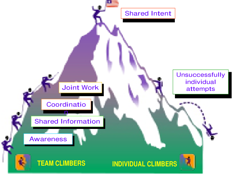

In [53]:
image.crop((bbox["x"], bbox["y"], (bbox["x"] + bbox["w"]), (bbox["y"] + bbox["h"])))

In [23]:
pages[4]['items']

[{'type': 'heading',
  'lvl': 2,
  'value': '6. Multimodal Roadmap',
  'md': '## 6. Multimodal Roadmap',
  'bBox': {'x': 100.56, 'y': 83.36, 'w': 131.5, 'h': 11.79}},
 {'type': 'text',
  'value': 'In an attempt to get a better handle on the future of this area, a recent Dagstuhl Workshop (Bunt, Maybury, and Wahlster 2001) drafted a baseline technology and capability roadmap for multimodality. As shown in Figure 6, the roadmap articulates three lanes to distinguish among developments in corpora analysis, advanced methods, and toolkits. These all lead to a medium term objective of creating mobile, human-centered and intelligent multimodal interfaces. For example, in the left lane labeled "empirical and data-driven models of multimodality", the group identified important steps toward multimodal corpora to include capturing examples of the value of multimodality, XML-encoding of human-human and human-machine multimodal corpora, analysis of frequency and complexity of phenomena, task specif